In [1]:
from shapely.geometry import Point
from geopandas import GeoSeries, GeoDataFrame
import geopandas as gpd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import string_utils

import pandas as pd
import seaborn as sns
import plotly.express as px
from textwrap import wrap
import numpy as np
from urllib.request import urlopen
import json
%matplotlib inline

# Introduction
## Cleaning Utilities
I've created a dataset "Dataset" in ahrf.py, which is utilized in ahrf_processing.py script for loading the original dataset, cleaning it, and saving it to a csv.


To do this just run ahrf_processing.py.
The processes in this script are as follows, and are documented in the script itself
* Organize data types
* Rename first 44 columns (geographical and nominal variables)
* Parse through AHRF2020-21 SAS file and use those column names rather than the 'f' codes (optional)
* Clean the string variables 
* Export to csv

## Exploratory Data Analysis
In the analysis I explore a few different variables at a state level and county level.

The code in this notebook is for variable selection and creation of the geographic choropleth maps.

In [2]:
data = pd.read_csv('ahrf_cleaned.csv')

c:\ProgramData\Anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (13,15,23,43,44,45,70,71,72,73,74,75,76,77,78,79,80,81,82,83) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Adding state and county combination column for easier analysis
data['state_&_county'] = data['FIPS State Code'] + data['FIPS County Code']

# Exploring Missing Values

In [6]:
num_vars = data.columns[data.dtypes != 'object']
cat_vars = data.columns[data.dtypes == 'object']

In [7]:
missing_percentages = data[num_vars].isnull().sum().sort_values(ascending=False) / len(data)

In [8]:
# Percentage of columns that have more than 20% of their data missing
len(missing_percentages[missing_percentages > 0.20]) / len(data)

0.12848297213622292

<AxesSubplot:ylabel='Count'>

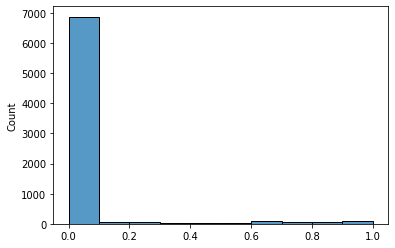

In [9]:
# Distribution of columns with percent null
sns.histplot(data[num_vars].isnull().sum().sort_values(ascending=False) / len(data), bins=10)

# Exploring Physicians By State
Looking at the average number of non-federal primary care physicians in each state from 2010-2019 and then normalized by population of state.

In [10]:
# B-1 Non Federal Primary Care Physicians.
physicians = data[['State Name Abbreviation', 'State Name', 'County Name', 'f1318219', 'f1467519', 'f1467518', 'f1467517', 'f1467516', 'f1467515', 'f1467514', 'f1467513', 'f1467512', 'f1467511', 'f1467510']]
physicians = physicians.rename(columns={'f1318219': 'Population'})

In [11]:
physicians['avg'] = physicians[['f1467519', 'f1467518', 'f1467517', 'f1467516', 'f1467515', 'f1467514', 'f1467513', 'f1467512', 'f1467511', 'f1467510']].sum(axis=1) / 10
phys_avg = pd.DataFrame(physicians.groupby('State Name Abbreviation')['avg'].mean()).reset_index()

In [12]:
# Average primary care physicians per state
phys_fig = px.choropleth(phys_avg,
                    locations='State Name Abbreviation', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='avg',
                    color_continuous_scale="peach", 
                    )
phys_fig.show()

In [13]:
physicians['normalized_avg'] = physicians['avg'] / physicians['Population']
phys_avg_normalized = pd.DataFrame(physicians.groupby('State Name Abbreviation')['normalized_avg'].mean()).reset_index()

In [14]:
# Average primary care physicians normalized by population
phys_fig_normalized = px.choropleth(phys_avg_normalized,
                    locations='State Name Abbreviation', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='normalized_avg',
                    color_continuous_scale="peach", 
                    )
phys_fig_normalized.show()

# Exploring Medicare

Here I explore the proportion of medicare beneficiaries in each county to how many are qualified for medicare benefits. I then take the average of the counties in each state and plot the results. 

This could give us an idea of the state of a state's medical care alternatives to medicare, though it is by no means telling 100%

In [15]:
medicare = data[['State Name Abbreviation', 'State Name', 'County Name', 'f1528819', 'f1319120']].rename(columns={'f1528819':'Medicare FFS Beneficiaries', 'f1319120':'Eligible for Medicare'})
medicare['medicare_normalized'] = medicare['Medicare FFS Beneficiaries'] / medicare['Eligible for Medicare']
medicare_normalized = pd.DataFrame(medicare.groupby('State Name Abbreviation')['medicare_normalized'].mean()).reset_index()

In [16]:
# Average by county in each state of proportion of medicare eligible people utilizing medicare
# 
medicare_fig = px.choropleth(medicare_normalized,
                    locations='State Name Abbreviation', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='medicare_normalized',
                    color_continuous_scale="darkmint", 
                    )
medicare_fig.show()

In [17]:
medicare_counties = data[['State Name', 'Secondary Entity Of File', 'County Name', 'f1528819', 'f1319120']].rename(columns={'f1528819':'Medicare FFS Beneficiaries', 'f1319120':'Eligible for Medicare', 'Secondary Entity Of File': 'GEOID'})
medicare_counties['GEOID'] = medicare_counties['GEOID'].astype(str)

medicare_counties['medicare_normalized'] = medicare_counties['Medicare FFS Beneficiaries'] / medicare_counties['Eligible for Medicare']

In [18]:
# Shapefile of US counties.
county_shapefile = gpd.read_file('cb_2018_us_county_500k/cb_2018_us_county_500k.shp')
county_shapefile['GEOID'] = county_shapefile['GEOID'].apply(string_utils.strip_front_zeros)
medicare_counties_geo = pd.merge(medicare_counties, county_shapefile, how='inner', on='GEOID')

Text(0.5, 1.0, 'Proportion of Medicare Beneficiaries (Among Eligible)')

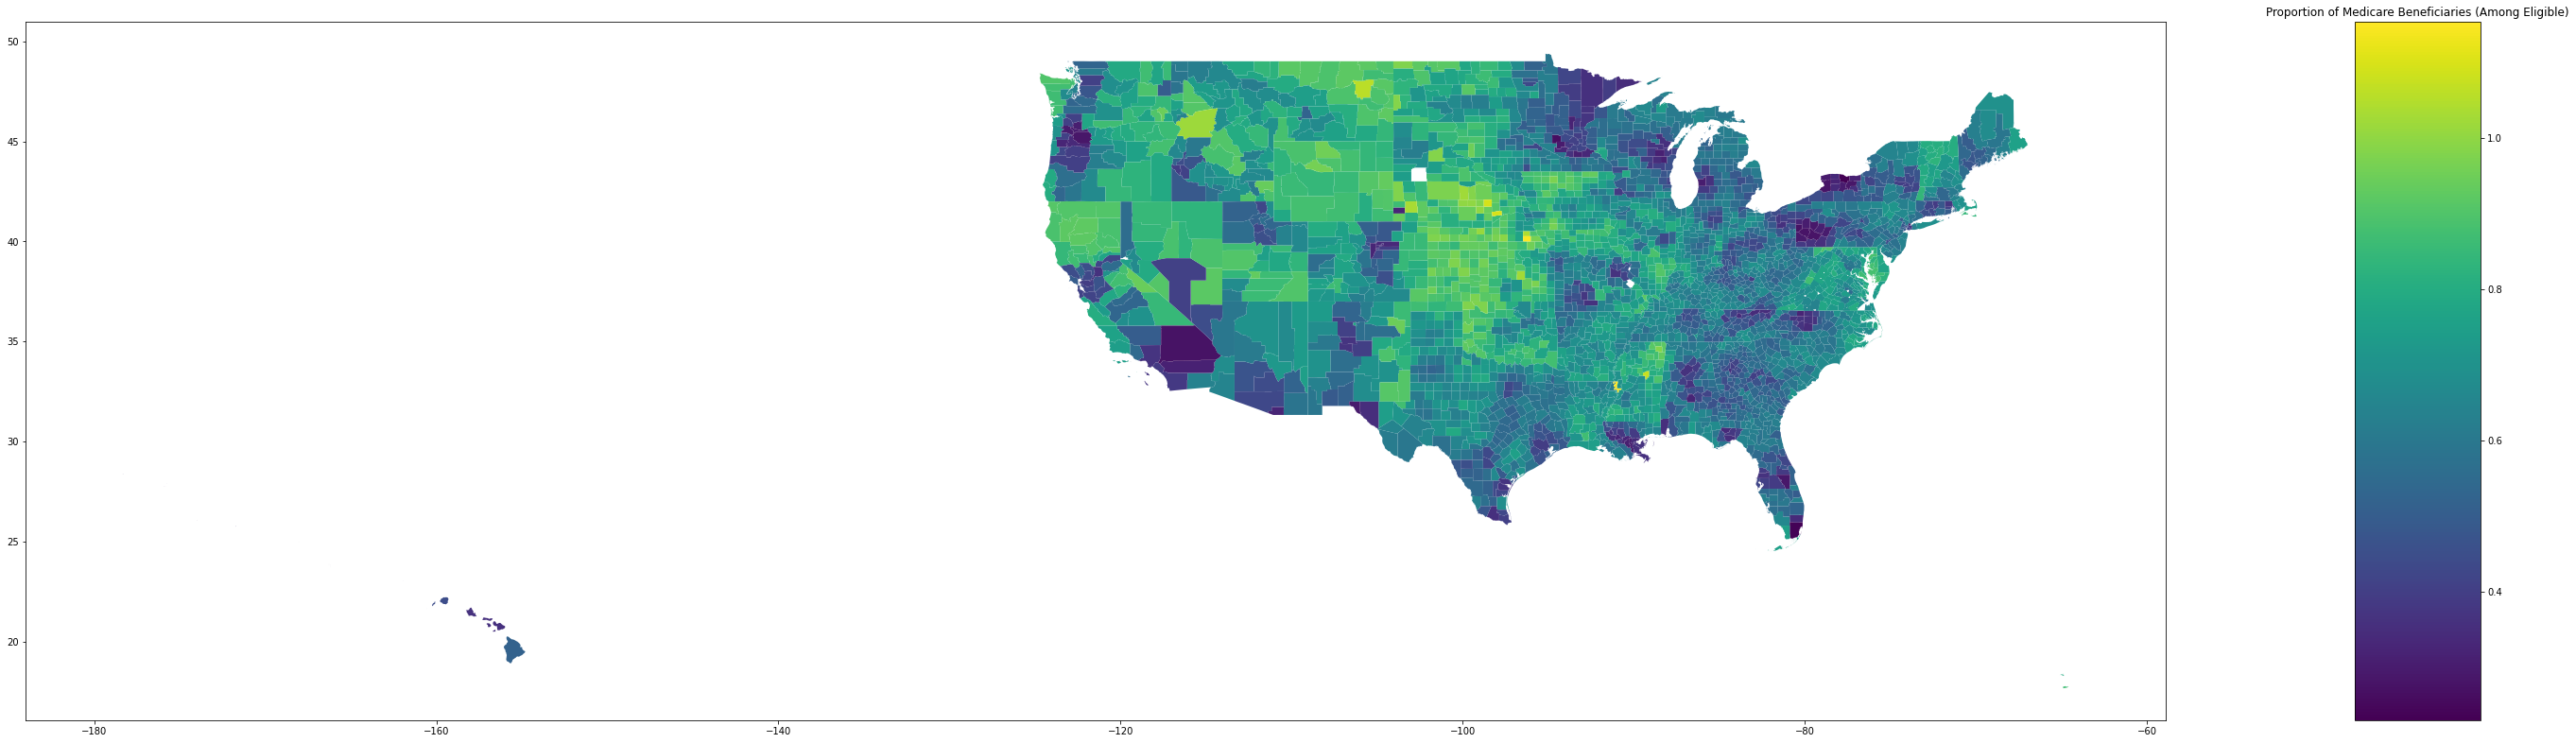

In [19]:
plt.rcParams["figure.figsize"] = (50,25)
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

np.random.seed(1)
DPI = 100

gpd.GeoDataFrame(medicare_counties_geo).plot(column='medicare_normalized', ax=ax, cax=cax, legend=True)
plt.xticks(rotation=45)
plt.title('Proportion of Medicare Beneficiaries (Among Eligible)')

### California Proportion of Medicare Beneficiaries (Among Eligible)

Text(0.5, 1.0, 'California Proportion of Medicare Beneficiaries (Among Eligible)')

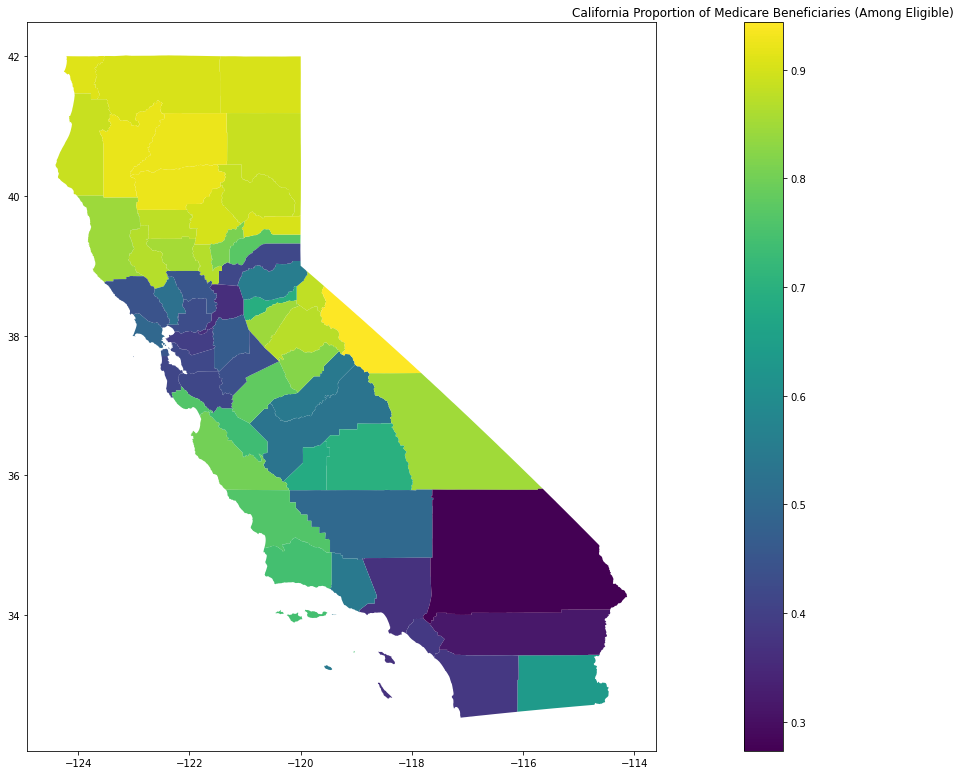

In [20]:
plt.rcParams["figure.figsize"] = (15,15)
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

np.random.seed(1)
DPI = 100

gpd.GeoDataFrame(medicare_counties_geo[medicare_counties_geo['State Name'] == "California"]).plot(column='medicare_normalized', ax=ax, cax=cax, legend=True)
plt.xticks(rotation=45)
plt.title('California Proportion of Medicare Beneficiaries (Among Eligible)')

### New Jersey Proportion of Medicare Beneficiaries (Among Eligible)

Text(0.5, 1.0, 'New Jersey Proportion of Medicare Beneficiaries (Among Eligible)')

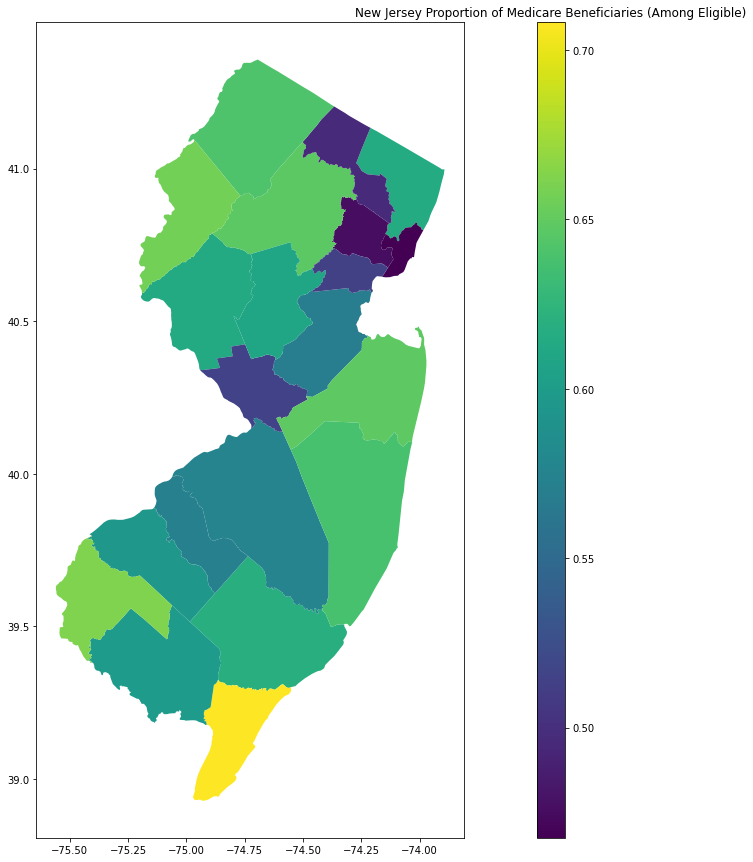

In [21]:
plt.rcParams["figure.figsize"] = (15,15)
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

np.random.seed(1)
DPI = 100

gpd.GeoDataFrame(medicare_counties_geo[medicare_counties_geo['State Name'] == "New Jersey"]).plot(column='medicare_normalized', ax=ax, cax=cax, legend=True)
plt.xticks(rotation=45)
plt.title('New Jersey Proportion of Medicare Beneficiaries (Among Eligible)')

In [22]:
# Available Color Schemes
named_colorscales = px.colors.named_colorscales()
print("\n".join(wrap("".join('{:<12}'.format(c) for c in named_colorscales), 96)))

aggrnyl     agsunset    blackbody   bluered     blues       blugrn      bluyl       brwnyl
bugn        bupu        burg        burgyl      cividis     darkmint    electric    emrld
gnbu        greens      greys       hot         inferno     jet         magenta     magma
mint        orrd        oranges     oryel       peach       pinkyl      plasma      plotly3
pubu        pubugn      purd        purp        purples     purpor      rainbow     rdbu
rdpu        redor       reds        sunset      sunsetdark  teal        tealgrn     turbo
viridis     ylgn        ylgnbu      ylorbr      ylorrd      algae       amp         deep
dense       gray        haline      ice         matter      solar       speed       tempo
thermal     turbid      armyrose    brbg        earth       fall        geyser      prgn
piyg        picnic      portland    puor        rdgy        rdylbu      rdylgn      spectral
tealrose    temps       tropic      balance     curl        delta       oxy         edge
hsv     